# Arabic NER Tagging Using Transformers <br>by **Mohammed Aly**
- [LinkedIn](https://www.linkedin.com/in/mohammedaly22/)  
- [GitHub](https://github.com/MohammedAly22/)

<html>
<img src="https://symbl.ai/wp-content/uploads/2022/08/What-Is-Named-Entity-Recognition-NER-and-What-Can-You-Do-with-It.png" width="100%">
</html>


in Natural Language Processing, **NER** stands for **Named Entity Recognition**. It is a subtask of information extraction that seeks to locate and classify named entities mentioned in unstructured text into predefined categories such as the **names of persons**, **organizations**, **locations**,, etc. NER systems typically use machine learning techniques to automatically identify and categorize entities within a body of text. It's widely used in various natural language processing applications like information retrieval, question answering, text summarization, and more.

Here are some common named entity tags:

| Tag              | Arabic Tag | Description |
| :---------------- | ------: | :---- |
| PER        |   اسم شخص   | refers to named entities that represent individual people or characters, whether real or fictional, mentioned within a text. |
| LOC           |   اسم عنوان   | represents named entities that denote specific locations, such as countries, cities, landmarks, and geographical features.|
| ORG    |  اسم مؤسسة   | denotes named entities that refer to organizations, institutions, companies, agencies, or any group of people with a common purpose or affiliation.|

# 1.0 Installing & Importing Required Packages

In [3]:
!pip install accelerate seqeval datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.9 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from seqeval.metrics import f1_score, accuracy_score

import torch
from torch.nn.functional import cross_entropy

from datasets import load_dataset

from transformers import (
    AutoTokenizer,
    XLMRobertaForTokenClassification,
    Trainer,
    TrainingArguments,
    AutoConfig,
    DataCollatorForTokenClassification
)

# 2.0 Loading & Inspecting the Dataset

In [5]:
ds = load_dataset('xtreme', name='PAN-X.ar')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [6]:
ds

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

In [8]:
ds['train'].features

{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None),
 'langs': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

## 2.1 Get the `ClassLabel` object

In [9]:
tags = ds['train'].features['ner_tags'].feature
tags

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)

## 2.2 Convert Class IDs to thier Corresponding Label

In [10]:
def create_tag_names(batch):
    return {'ner_tags_str': [tags.int2str(idx) for idx in batch['ner_tags']]}

ds = ds.map(create_tag_names)

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [11]:
ds

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 10000
    })
})

In [16]:
example = ds['train'][200]
pd.DataFrame([example['tokens'], example['ner_tags_str']], index=['Tokens', 'Tags'])

,0,1,2,3,4
Tokens,يارا,(,مغنية,),.
Tags,B-PER,I-PER,I-PER,I-PER,O


In [17]:
for k, v in example.items():
    print(f"{k}: {v}")

tokens: ['يارا', '(', 'مغنية', ')', '.']
ner_tags: [1, 2, 2, 2, 0]
langs: ['ar', 'ar', 'ar', 'ar', 'ar']
ner_tags_str: ['B-PER', 'I-PER', 'I-PER', 'I-PER', 'O']


## 2.3 Create `index2tag` and `tag2index`

In [18]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

print(index2tag)
print(tag2index)

{0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC'}
{'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6}


# 3.0 Peparing the Dataset

## 3.1 Loading and Testing the Tokenizer

In [19]:
xlmr_model_name = 'xlm-roberta-base'

xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

text = 'اسمي محمد و اسكن في القاهرة'
xlmr_tokens = xlmr_tokenizer(text).tokens()
print(xlmr_tokens)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

['<s>', '▁اسم', 'ي', '▁محمد', '▁و', '▁اس', 'كن', '▁في', '▁القاهرة', '</s>']


## 3.2 Creating the `xlmr_config`

In [20]:
xlmr_config = AutoConfig.from_pretrained(
    xlmr_model_name,
    num_labels=tags.num_classes,
    id2label=index2tag,
    label2id=tag2index
)

## 3.3 Loading the `XLMRobertaForTokenClassification` Model


In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
xlmr_model = (
    XLMRobertaForTokenClassification.from_pretrained(
        xlmr_model_name,
        config=xlmr_config
    ).to(device)
)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 3.4 Testing the Model before Fine-Tuning

In [22]:
input_ids = xlmr_tokenizer.encode(text, return_tensors='pt')
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=['Tokens', 'Input IDs'])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁اسم,ي,▁محمد,▁و,▁اس,كن,▁في,▁القاهرة,</s>
Input IDs,0,20162,179,2977,65,754,37395,240,73267,2


In [23]:
outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim=-1)

print(f'Number of tokens in sequence: {len(xlmr_tokens)}')
print(f'Shape of outputs: {outputs.shape}')

Number of tokens in sequence: 10
Shape of outputs: torch.Size([1, 10, 7])


In [25]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=['Tokens', 'Tags'])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁اسم,ي,▁محمد,▁و,▁اس,كن,▁في,▁القاهرة,</s>
Tags,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG


## 3.5 Warapping all the Pervious Steps in a Function

In [26]:
def tag_text(text, tags, model, tokenizer):
    """
    Tokenize and predict the tags for given `text`.

    Parameters
    ----------
    - text : str
        A string for tokenization.
    - tags : datasets.ClassLabel
        A ClassLabel object for mapping tags to integers and vise versa.
    - model : transformers.XLMRobrtaForTokenClassification
        A PyTorch model for preforming token classification.
    - tokenizer : transformers.AutoTokenizer
        An AutoTokenizer associated with `model` for tokenizing `text`.

    Returns
    -------
    - pd.DataFrame
        A pandas dataframe contains input_tokens with their associated
        tags.
    """

    # Get tokens with special characters
    tokens = tokenizer(text).tokens()
    # Encode the sequence into IDs
    input_ids = tokenizer(text, return_tensors='pt').input_ids.to(device)
    # Get predictions as distribution over 7 possible classes
    outputs = model(input_ids)[0]
    # Take argmax to get most likely class per token
    predictions = torch.argmax(outputs, dim=2)
    # Convert to DataFrame
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]

    return pd.DataFrame([tokens, preds], index=['Tokens', 'Tags'])

## 3.6 Creating `tokenize_and_align_labels` function

In [35]:
def tokenize_and_align_labels(examples):
    """
    Tokenize and align the labels for given `examples`.

    Parameters
    ----------
    - examples : dict
        A dictionary represents a single batch from the dataset.

    Returns
    -------
    - dict
        A dictionary contains the new `labels` value.
    """

    tokenized_inputs = xlmr_tokenizer(
        examples['tokens'],
        truncation=True,
        is_split_into_words=True
    )
    labels = []

    for idx, label in enumerate(examples['ner_tags']):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs['labels'] = labels
    return tokenized_inputs

## 3.7 Tokenizing the Dataset

In [36]:
def encode_dataset(corpus):
    return corpus.map(
        tokenize_and_align_labels,
        batched=True,
        remove_columns=['langs', 'ner_tags', 'tokens']
    )

In [37]:
ds_encoded = encode_dataset(ds)

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [38]:
ds_encoded

DatasetDict({
    train: Dataset({
        features: ['ner_tags_str', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['ner_tags_str', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['ner_tags_str', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 10000
    })
})

In [39]:
print(f"input_ids: {ds_encoded['train'][0]['input_ids']}")
print(f"labels:    {ds_encoded['train'][0]['labels']}")

input_ids: [0, 181, 42083, 15, 21215, 1388, 2]
labels:    [-100, 3, -100, 4, 4, 4, -100]


# 4.0 Fine-Tuning

## 4.1 Create Useful Functions
- `align_predictions()`: This function is used to align predicitons with label_ids as they are needed to be in form `list of lists` to be evaluated using `seqeval` pacakge.

- `compute_metrics()`: This function is used in Hugging Face Trainer API to specify which metrics we need to test the model to during training. It takes an argument of type `EvalPrediciton` which contains our **predictions** and corresponding **label_ids**

In [50]:
def align_predictions(predictions, label_ids):
    """
    Convert `predictions` and `label_ids` to a list of lists
    which is the format that `seqeval` can deal with.

    Parameters
    ----------
    - predictions : np.ndarray
        A numpy array of predicitons.
    - label_ids : np.ndarray
        A numpy array of original label ids.

    Returns
    -------
    - tuple[list, list]
        Returns `preds_list` and `labels_list` which are a list of
        lists of the `predictions` and `label_ids`.
    """

    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list


def compute_metrics(eval_pred):
    """
    Overriding the original `compute_metrics` function of
    the Trainer API.

    Parameters
    ----------
    - eval_pred : datasets.EvalPrediction
        An EvalPrediction object contains predictions and the
        original label_ids.

    Returns
    -------
    - dict
        A dictionary contains the specifc seqeval metrics needed
        to evaluate the model.
    """

    y_pred, y_true = align_predictions(eval_pred.predictions, eval_pred.label_ids)

    return {'f1': f1_score(y_true, y_pred), 'accuracy': accuracy_score(y_true, y_pred)}

## 4.2 Define the `TrainingArguments`, `DataCollatorForTokenClassification`, and `Trainer` API

In [51]:
num_epochs = 3
batch_size = 16
logging_steps = len(ds_encoded['train']) // batch_size
model_name = 'arabnizer-xlmr-panx-ar'

training_arguments = TrainingArguments(
    output_dir=model_name,
    log_level='error',
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy='epoch',
    save_steps=1e6,
    weight_decay=0.01,
    disable_tqdm=False,
    logging_steps=logging_steps
)


data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

trainer = Trainer(
    model=xlmr_model,
    args=training_arguments,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    train_dataset=ds_encoded['train'],
    eval_dataset=ds_encoded['validation'],
    tokenizer=xlmr_tokenizer
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


## 4.3 Start Fine-Tuning

In [52]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.203100,0.207782,0.859793,0.942558
2,0.155900,0.204332,0.873610,0.948951
3,0.099200,0.207264,0.888544,0.953322


TrainOutput(global_step=3750, training_loss=0.1527435770670573, metrics={'train_runtime': 773.3161, 'train_samples_per_second': 77.588, 'train_steps_per_second': 4.849, 'total_flos': 890302790816736.0, 'train_loss': 0.1527435770670573, 'epoch': 3.0})

## 4.4 Testing the Model

In [53]:
predictions = trainer.predict(ds_encoded['test'])
predictions.metrics

{'test_loss': 0.22424550354480743,
 'test_f1': 0.8797913258764755,
 'test_accuracy': 0.949072994856015,
 'test_runtime': 18.9665,
 'test_samples_per_second': 527.245,
 'test_steps_per_second': 32.953}

# 5.0 Error Analysis

## 5.1 Get the Dataset of Losses per Predicttion

In [75]:
def forward_pass_with_label(batch):
    """
    Get the loss and the predicted label for each example (token level)
    in the passed `batch`.

    Parameters
    ----------
    - batch : dict
        A dictionary represents a single batch from the dataset.

    Returns
    -------
    - dict
        A dictionary contains 2 new columns per example `loss` and
        `predicted_label` for each token in the example.
    """

    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]

    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    with torch.no_grad():
        output = trainer.model(input_ids, attention_mask)
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()

    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, 7), labels.view(-1), reduction='none')

    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {'loss': loss, 'predicted_label': predicted_label}

In [81]:
test_set = ds_encoded['test'].remove_columns('ner_tags_str')
test_set = test_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = test_set.to_pandas()

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [82]:
df.head()

,input_ids,attention_mask,labels,loss,predicted_label
0,"[0, 94643, 240, 51202, 7425, 5116, 112669, 146...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 0, 3, 4, -100, 4, -100, 4, 0, -100, ...","[0.0, 0.00011920219, 0.0001633034, 0.000749307...","[4, 0, 0, 3, 4, 4, 4, 4, 4, 0, 0, 4, 4, 4, 4, ..."
1,"[0, 6, 78456, 4102, 4392, 15, 6, 194715, 3047,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, -100, 5, -100, 6, 6, -100, 6, -100, ...","[0.0, 7.569503e-05, 0.0, 0.00072417257, 0.0, 0...","[5, 0, 0, 5, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, ..."
2,"[0, 6, 78456, 2231, 18726, 53178, 2000, 17977,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, -100, 1, -100, -100, 2, -100, -100, ...","[0.0, 7.414543e-05, 0.0, 0.009787782, 0.0, 0.0...","[2, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
3,"[0, 6, 78456, 6, 194715, 14339, 15, 4003, 1391...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, -100, 5, -100, 6, 6, 6, -100, 6, -100]","[0.0, 7.819824e-05, 0.0, 0.00085162604, 0.0, 0...","[5, 0, 0, 5, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, ..."
4,"[0, 6, 78456, 99391, 174197, 136212, 240, 1087...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, -100, 5, 6, 6, 6, 6, 6, -100]","[0.0, 7.641024e-05, 0.0, 0.0037671805, 0.00357...","[6, 0, 0, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ..."


## 5.2 Converting the Result Into a Human-Readable Format

In [83]:
index2tag[-100] = 'IGN'
df['input_tokens'] = df['input_ids'].apply(lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df['text'] = df['input_tokens'].apply(lambda x: xlmr_tokenizer.convert_tokens_to_string(x))
df['predicted_label'] = df['predicted_label'].apply(lambda x: [index2tag[i] for i in x])
df['labels'] = df['labels'].apply(lambda x: [index2tag[i] for i in x])
df['loss'] = df.apply(lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)

In [84]:
df.head()

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens,text
0,"[0, 94643, 240, 51202, 7425, 5116, 112669, 146...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, O, O, B-ORG, I-ORG, IGN, I-ORG, IGN, I-O...","[0.0, 0.00011920219, 0.0001633034, 0.000749307...","[I-ORG, O, O, B-ORG, I-ORG, I-ORG, I-ORG, I-OR...","[<s>, ▁تعلم, ▁في, ▁جامعة, ▁نور, ث, ▁وست, رن, ▁...",<s> تعلم في جامعة نورث وسترن في .</s>
1,"[0, 6, 78456, 4102, 4392, 15, 6, 194715, 3047,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, O, IGN, B-LOC, IGN, I-LOC, I-LOC, IGN, I...","[0.0, 7.569503e-05, 0.0, 0.00072417257, 0.0, 0...","[B-LOC, O, O, B-LOC, I-LOC, I-LOC, I-LOC, I-LO...","[<s>, ▁, تحويل, ▁ده, ▁شهر, ▁(, ▁, مقاطعة, ▁كل,...",<s> تحويل ده شهر ( مقاطعة كلاردشت )</s>
2,"[0, 6, 78456, 2231, 18726, 53178, 2000, 17977,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, O, IGN, B-PER, IGN, IGN, I-PER, IGN, IGN...","[0.0, 7.414543e-05, 0.0, 0.009787782, 0.0, 0.0...","[I-PER, O, O, B-PER, I-PER, I-PER, I-PER, I-PE...","[<s>, ▁, تحويل, ▁وي, لف, ريد, ▁أو, رب, اين, ▁إ...",<s> تحويل ويلفريد أورباين إيلفيس إندزانغا</s>
3,"[0, 6, 78456, 6, 194715, 14339, 15, 4003, 1391...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, O, IGN, B-LOC, IGN, I-LOC, I-LOC, I-LOC,...","[0.0, 7.819824e-05, 0.0, 0.00085162604, 0.0, 0...","[B-LOC, O, O, B-LOC, I-LOC, I-LOC, I-LOC, I-LO...","[<s>, ▁, تحويل, ▁, مقاطعة, ▁روش, ▁(, ▁كان, ساس...",<s> تحويل مقاطعة روش ( كانساس )</s>
4,"[0, 6, 78456, 99391, 174197, 136212, 240, 1087...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, O, IGN, B-LOC, I-LOC, I-LOC, I-LOC, I-LO...","[0.0, 7.641024e-05, 0.0, 0.0037671805, 0.00357...","[I-LOC, O, O, B-LOC, I-LOC, I-LOC, I-LOC, I-LO...","[<s>, ▁, تحويل, ▁قائمة, ▁المواضيع, ▁الأساسية, ...",<s> تحويل قائمة المواضيع الأساسية في علم الاجت...


## 5.3 Looking at a Specific Example

In [85]:
i = 0
example = df.iloc[i]

print(f"text: {example['text']}\n")
print(f"tokens: {example['input_tokens']}\n")
print(f"label: {example['labels']}\n")
print(f"preds: {example['predicted_label']}\n")

text: <s> تعلم في جامعة نورث وسترن في .</s>

tokens: ['<s>', '▁تعلم', '▁في', '▁جامعة', '▁نور', 'ث', '▁وست', 'رن', '▁في', '▁', '.', '</s>']

label: ['IGN', 'O', 'O', 'B-ORG', 'I-ORG', 'IGN', 'I-ORG', 'IGN', 'I-ORG', 'O', 'IGN', 'IGN']

preds: ['I-ORG', 'O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'O', 'O', 'I-ORG']



## 5.4 Exploding the Result to get Loss for Each Indvidual Word

In [86]:
df.reset_index(inplace=True)
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens.head()

,index,input_ids,attention_mask,labels,loss,predicted_label,input_tokens,text
0,0,94643,1,O,0.000119,O,▁تعلم,<s> تعلم في جامعة نورث وسترن في .</s>
0,0,240,1,O,0.000163,O,▁في,<s> تعلم في جامعة نورث وسترن في .</s>
0,0,51202,1,B-ORG,0.000749,B-ORG,▁جامعة,<s> تعلم في جامعة نورث وسترن في .</s>
0,0,7425,1,I-ORG,0.001064,I-ORG,▁نور,<s> تعلم في جامعة نورث وسترن في .</s>
0,0,112669,1,I-ORG,0.001257,I-ORG,▁وست,<s> تعلم في جامعة نورث وسترن في .</s>


In [87]:
df_tokens['loss'] = df_tokens['loss'].astype(float).round(2)
df_tokens.head()

,index,input_ids,attention_mask,labels,loss,predicted_label,input_tokens,text
0,0,94643,1,O,0.0,O,▁تعلم,<s> تعلم في جامعة نورث وسترن في .</s>
0,0,240,1,O,0.0,O,▁في,<s> تعلم في جامعة نورث وسترن في .</s>
0,0,51202,1,B-ORG,0.0,B-ORG,▁جامعة,<s> تعلم في جامعة نورث وسترن في .</s>
0,0,7425,1,I-ORG,0.0,I-ORG,▁نور,<s> تعلم في جامعة نورث وسترن في .</s>
0,0,112669,1,I-ORG,0.0,I-ORG,▁وست,<s> تعلم في جامعة نورث وسترن في .</s>


## 5.5 Looking at the **Top 10** Highest Loss Input Tokens

In [88]:
(
    df_tokens.groupby('input_tokens')[['loss']]
    .agg(['count', 'mean', 'sum'])
    .droplevel(level=0, axis=1)
    .sort_values(by='sum', ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁(,▁),▁في,▁ال,▁الم,▁دي,▁و,▁إ,▁بن
count,9851,3478,3479,1279,700,761,224,397,313,585
mean,0.09,0.18,0.17,0.23,0.4,0.21,0.54,0.29,0.36,0.19
sum,902.74,616.77,594.15,299.11,283.49,159.21,121.64,115.99,113.86,109.71


## 5.6 Looking at the **Top 10** Highest Loss Input Tokens

In [89]:
(
    df_tokens.groupby('labels')[['loss']]
    .agg(['count', 'mean', 'sum'])
    .droplevel(level=0, axis=1)
    .sort_values(by='mean', ascending=False)
    .reset_index()
    .round(2)
    .T
)

,0,1,2,3,4,5,6
labels,B-ORG,B-LOC,B-PER,I-PER,I-ORG,I-LOC,O
count,3629,3780,3850,7937,10045,9073,26033
mean,0.55,0.35,0.34,0.32,0.32,0.24,0.07
sum,1985.79,1311.39,1308.8,2526.67,3175.9,2181.21,1865.49


## 5.7 Confusion Matrix

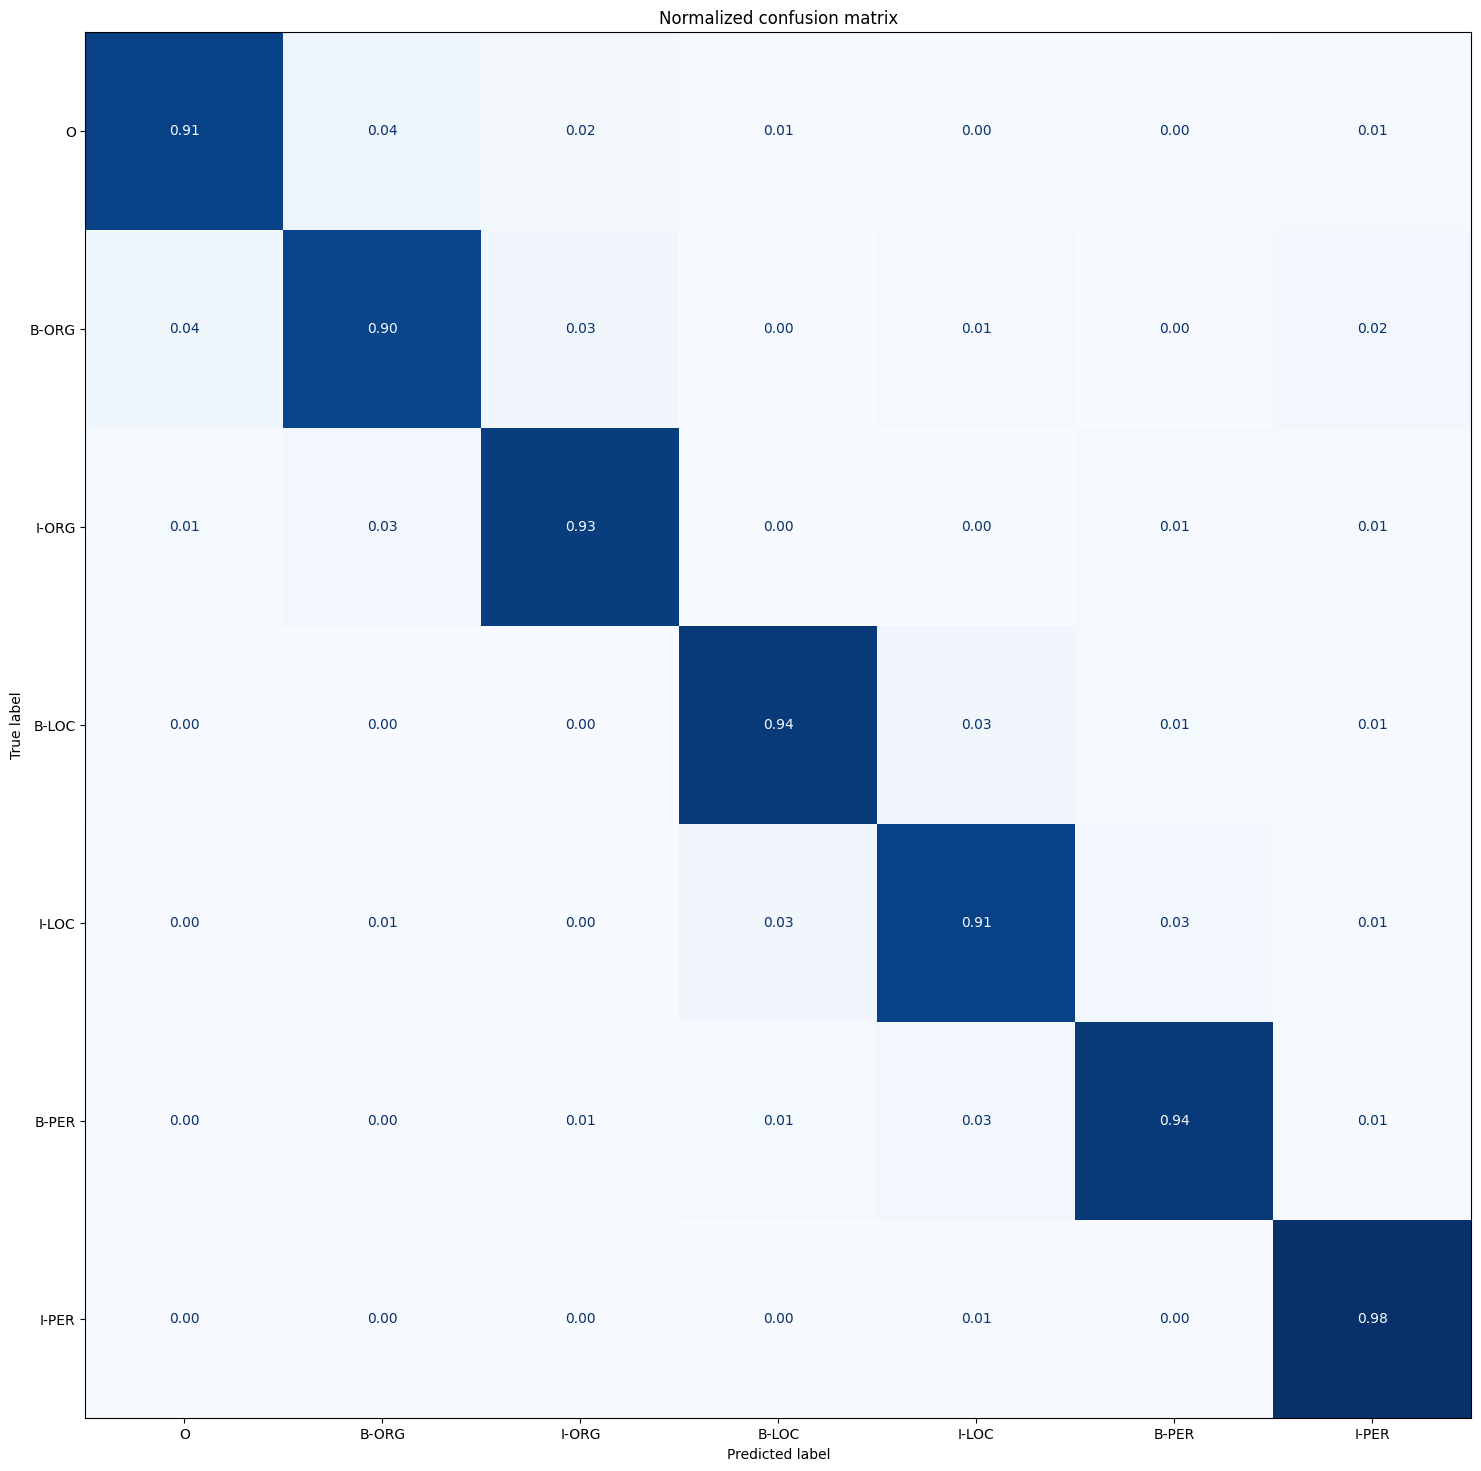

In [90]:
def plot_confusion_matrix(y_preds, y_true, labels):
    """
    Plot confusion 18x18 matrix.

    Parameters
    ----------
    - y_preds : np.ndarray
        A numpy array contains the predictions.
    - y_true : np.ndarray
        A numpy array contains the original label_ids.
    - labels : list
        A list of labels names.
    """

    cm = confusion_matrix(y_true, y_preds, normalize='true')

    _, ax = plt.subplots(figsize=(18, 18))

    ax.set(
         xticks=np.arange(len(labels)),
         yticks=np.arange(len(labels)),
         xticklabels=labels,
         yticklabels=labels
    )
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.title('Normalized confusion matrix')
    plt.show()

plot_confusion_matrix(df_tokens['labels'], df_tokens['predicted_label'], df_tokens['labels'].unique().tolist())

# 6.0 Using the Model at Inference

## 6.1 Pushing the Model to the Hub

In [91]:
from huggingface_hub import notebook_login

notebook_login()

In [92]:
trainer.push_to_hub('Commit Successfully')

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

events.out.tfevents.1711133558.aaa0cc1fbcb4.510.0:   0%|          | 0.00/4.89k [00:00<?, ?B/s]

events.out.tfevents.1711133708.aaa0cc1fbcb4.510.1:   0%|          | 0.00/4.89k [00:00<?, ?B/s]

events.out.tfevents.1711133928.aaa0cc1fbcb4.510.2:   0%|          | 0.00/6.98k [00:00<?, ?B/s]

Upload 7 LFS files:   0%|          | 0/7 [00:00<?, ?it/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.92k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/mohammedaly22/arabnizer-xlmr-panx-ar/commit/49fd0715cbe7ecb1d14413dd0b1449843a70a0a1', commit_message='Commit Successfully', commit_description='', oid='49fd0715cbe7ecb1d14413dd0b1449843a70a0a1', pr_url=None, pr_revision=None, pr_num=None)

## 6.2 Loading the Model as a Hugging Face `pipeline`

In [98]:
from transformers import pipeline

ner_tagger = pipeline('token-classification', 'mohammedaly22/arabnizer-xlmr-panx-ar')

In [102]:
text = 'اسمي محمد، اعمل في شركة اورانج و اسكن في القاهرة.'
ner_tagger(text, grouped_entities=True)

[{'entity_group': 'PER',
  'score': 0.9486102,
  'word': 'محمد',
  'start': 5,
  'end': 9},
 {'entity_group': 'ORG',
  'score': 0.8212871,
  'word': 'اورانج',
  'start': 24,
  'end': 30},
 {'entity_group': 'LOC',
  'score': 0.9967932,
  'word': 'القاهرة',
  'start': 41,
  'end': 48}]

In [105]:
ner_tagger(text, grouped_entities=True)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/token_classification.py:168: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="simple"` instead.
  warnings.warn(


[{'entity_group': 'PER',
  'score': 0.9486102,
  'word': 'محمد',
  'start': 5,
  'end': 9},
 {'entity_group': 'ORG',
  'score': 0.8212871,
  'word': 'اورانج',
  'start': 24,
  'end': 30},
 {'entity_group': 'LOC',
  'score': 0.9967932,
  'word': 'القاهرة',
  'start': 41,
  'end': 48}]